In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from mxnet import autograd, nd, init as ginit
from mxnet.gluon import nn, loss as gloss, data as gdata, Trainer as gTrainer

In [2]:
# 读取数据 using pandas
train_data = pd.read_csv("./DataResources/PA_1/train.csv")
test_data = pd.read_csv("./DataResources/PA_1/test.csv")

### 预处理数据
1. 了解各column的意义和值的分布: 所有列都会参与训练
2. dtype为object的列 被拆分成几列
3. dtype不为object将被归一化, 并且训练集和测试集一起归一化
4. 填补非object列的缺失值

In [3]:
def explore_dtype():
    for dtype in ['object', 'int', 'float']:
        single_type = train_data.select_dtypes(include=[dtype])
        print(dtype, ": ", single_type.shape[1], ": ", ",".join(single_type.columns))
explore_dtype()

object :  43 :  MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
int :  35 :  Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
float :  3 :  LotFrontage,MasVnrArea,GarageYrBlt


In [4]:
def preprocess(train_data, test_data):
    # 合并
    # exclude label and id
    # 使用iloc小心, 维度之间用comma隔开, 而不是 ][
    all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]), sort=False)
    numerical_index = all_features.dtypes[all_features.dtypes != 'object'].index
    all_features[numerical_index] = all_features[numerical_index].apply(lambda x: (x - x.mean()) / x.std())
    all_features[numerical_index] = all_features[numerical_index].fillna(0)  # 如果归一化在fillna之后会如何
    flat_features = pd.get_dummies(all_features, dummy_na=True)  # nan 也作为一类
    return flat_features


def simply_data(train_data, test_data):
    all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]), sort=False)
    need_indices = ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'YearBuilt']
    sub_features = all_features[need_indices]
    sub_features = sub_features.apply(lambda x: (x - x.mean()) / x.std())
    sub_features = sub_features.fillna(0)
    return sub_features

In [5]:
# flat_features = preprocess(train_data, test_data)
flat_features = preprocess(train_data, test_data)

In [6]:
flat_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [7]:
train_X = nd.array(flat_features.iloc[:train_data.shape[0], :].to_numpy())
train_y = nd.array(train_data.iloc[:, -1]).reshape((train_data.shape[0], 1))
test_X = nd.array(flat_features.iloc[train_data.shape[0]:, :].to_numpy())

In [8]:
train_X


[[ 0.06731988 -0.18444261 -0.21784137 ...  1.          0.
   0.        ]
 [-0.8734664   0.45809588 -0.07203174 ...  1.          0.
   0.        ]
 [ 0.06731988 -0.05593492  0.13717337 ...  1.          0.
   0.        ]
 ...
 [ 0.30251643 -0.14160672 -0.14278111 ...  1.          0.
   0.        ]
 [-0.8734664  -0.05593492 -0.0571972  ...  1.          0.
   0.        ]
 [-0.8734664   0.24391638 -0.02930318 ...  1.          0.
   0.        ]]
<NDArray 1460x331 @cpu(0)>

In [9]:
train_y


[[208500.]
 [181500.]
 [223500.]
 ...
 [266500.]
 [142125.]
 [147500.]]
<NDArray 1460x1 @cpu(0)>

In [10]:
test_X


[[-0.8734664   0.45809588  0.18433963 ...  1.          0.
   0.        ]
 [-0.8734664   0.5009318   0.5197018  ...  1.          0.
   0.        ]
 [ 0.06731988  0.20108049  0.4642941  ...  1.          0.
   0.        ]
 ...
 [-0.8734664   3.8849678   1.2465944  ...  0.          0.
   0.        ]
 [ 0.6553113  -0.3129503   0.03459947 ...  1.          0.
   0.        ]
 [ 0.06731988  0.20108049 -0.06860839 ...  1.          0.
   0.        ]]
<NDArray 1459x331 @cpu(0)>

In [11]:
train_X.shape

(1460, 331)

In [12]:
test_X.shape

(1459, 331)

### 定义模型
1. 输入层: 331
2. 输出层: 1

In [13]:
hidden_layer_1, hidden_layer_2, output_layer = 300, 100, 1

In [14]:
def sqrt_loss(y_hat, y):
    # 要求是dim*1的向量
    loss = gloss.L2Loss()
    assert y_hat.shape == y.shape
    assert y_hat.shape[-1] == 1
    return nd.sqrt(2 * loss(y_hat, y)).mean().asscalar()

In [15]:
sqrt_loss(train_y, train_y)

0.0

### 训练模型

In [63]:
num_epochs = 1000
batch_size = 146
weight_decay = 1
learning_rate = 3

In [17]:
for X, y in gdata.DataLoader(gdata.ArrayDataset(train_X, train_y), batch_size=batch_size, shuffle=True):
    print(X, y.T)
    print(X.shape, y.shape)
    break


[[ 0.06731988  0.5437677  -0.0276549  ...  0.          0.
   0.        ]
 [-0.8734664   1.6575011   0.38099244 ...  1.          0.
   0.        ]
 [-0.8734664   0.67227536 -0.21150182 ...  0.          0.
   0.        ]
 ...
 [-0.16787669 -0.39862213  0.03447268 ...  1.          0.
   0.        ]
 [ 0.06731988  0.          0.28095436 ...  1.          0.
   0.        ]
 [ 0.06731988  0.67227536  0.1185351  ...  0.          1.
   0.        ]]
<NDArray 146x331 @cpu(0)> 
[[290000. 325000.  98600. 380000. 124000. 266500. 107000. 186500. 219500.
  175000. 125500. 124500. 136000. 155000. 131400. 120000. 163990. 372500.
  215200. 194000. 325000. 127000. 112000. 212000. 188000. 305000. 155000.
  175900. 115000.  81000. 121600. 318000. 105000. 160000. 303477. 240000.
  101000. 184900. 135000. 147400.  83000. 125000.  79000. 200624. 216000.
  179200. 385000. 348000. 143000. 165500. 110500. 133000. 150900. 217000.
  187000. 215000. 230000. 112500. 187500. 157000. 196000. 158900. 219210.
  156000. 

In [46]:
def train_net_sgd(net, loss, num_epochs, learning_rate):
    train_hist = list()
    parameters = net.collect_params()
    sgd_trainer = gTrainer(parameters, 'sgd', {'learning_rate': learning_rate})
    train_dataset = gdata.ArrayDataset(train_X, train_y)
    for epoch in range(num_epochs):
        for X, y in gdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            sgd_trainer.step(batch_size)
        # print('weight:', net[0].weight.data().asnumpy(), '\nbias:', net[0].bias.data().asnumpy())
        error = sqrt_loss(net(train_X), train_y)
        train_hist.append(error)
        print("{}-th ieration, sqrt loss: {}".format(epoch+1, error))
    return train_hist


def train_net_adam(net, loss, num_epochs, learning_rate, weight_decay):
    train_hist = list()
    parameters = net.collect_params()
    adam_trainer = gTrainer(parameters, 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    train_dataset = gdata.ArrayDataset(train_X, train_y)
    for epoch in range(num_epochs):
        for X, y in gdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            adam_trainer.step(batch_size)
        # print('weight:', net[0].weight.data().asnumpy(), '\nbias:', net[0].bias.data().asnumpy())
        error = sqrt_loss(net(train_X), train_y)
        train_hist.append(error)
        print("{}-th ieration, sqrt loss: {}".format(epoch+1, error))
    return train_hist

In [29]:
def get_net():
    net = nn.Sequential()
    # net.add(nn.Dense(hidden_layer_1), nn.Dense(hidden_layer_2), nn.Dense(output_layer))
    # net.add(nn.Dense(hidden_layer_1), nn.Dense(output_layer))
    net.add(nn.Dense(output_layer))
    net.initialize(ginit.Normal(sigma=0.01))  # Actual initialization happens during the first forward pass.
    return net

In [62]:
net = get_net()
loss = gloss.L2Loss()
# train_hist = train_net_sgd(net, loss, num_epochs, learning_rate)
train_hist = train_net_adam(net, loss, num_epochs, learning_rate, weight_decay)

1-th ieration, sqrt loss: 179607.125
2-th ieration, sqrt loss: 178294.921875
3-th ieration, sqrt loss: 176988.390625
4-th ieration, sqrt loss: 175686.203125
5-th ieration, sqrt loss: 174389.015625
6-th ieration, sqrt loss: 173098.71875
7-th ieration, sqrt loss: 171812.046875
8-th ieration, sqrt loss: 170530.046875
9-th ieration, sqrt loss: 169257.828125
10-th ieration, sqrt loss: 167985.9375
11-th ieration, sqrt loss: 166723.578125
12-th ieration, sqrt loss: 165463.25
13-th ieration, sqrt loss: 164210.875
14-th ieration, sqrt loss: 162963.9375
15-th ieration, sqrt loss: 161720.125
16-th ieration, sqrt loss: 160483.46875
17-th ieration, sqrt loss: 159250.390625
18-th ieration, sqrt loss: 158023.21875
19-th ieration, sqrt loss: 156806.828125
20-th ieration, sqrt loss: 155592.46875
21-th ieration, sqrt loss: 154379.6875
22-th ieration, sqrt loss: 153171.84375
23-th ieration, sqrt loss: 151971.640625
24-th ieration, sqrt loss: 150776.1875
25-th ieration, sqrt loss: 149587.40625
26-th ierat

204-th ieration, sqrt loss: 29501.0703125
205-th ieration, sqrt loss: 29324.923828125
206-th ieration, sqrt loss: 29157.291015625
207-th ieration, sqrt loss: 28991.85546875
208-th ieration, sqrt loss: 28830.892578125
209-th ieration, sqrt loss: 28676.8984375
210-th ieration, sqrt loss: 28522.654296875
211-th ieration, sqrt loss: 28373.66015625
212-th ieration, sqrt loss: 28228.482421875
213-th ieration, sqrt loss: 28088.4765625
214-th ieration, sqrt loss: 27948.306640625
215-th ieration, sqrt loss: 27819.41015625
216-th ieration, sqrt loss: 27691.666015625
217-th ieration, sqrt loss: 27568.337890625
218-th ieration, sqrt loss: 27442.076171875
219-th ieration, sqrt loss: 27330.46484375
220-th ieration, sqrt loss: 27213.240234375
221-th ieration, sqrt loss: 27105.076171875
222-th ieration, sqrt loss: 26997.298828125
223-th ieration, sqrt loss: 26892.599609375
224-th ieration, sqrt loss: 26793.107421875
225-th ieration, sqrt loss: 26692.427734375
226-th ieration, sqrt loss: 26599.14257812

398-th ieration, sqrt loss: 22362.6953125
399-th ieration, sqrt loss: 22354.66796875
400-th ieration, sqrt loss: 22347.1796875
401-th ieration, sqrt loss: 22339.1875
402-th ieration, sqrt loss: 22331.40234375
403-th ieration, sqrt loss: 22327.4453125
404-th ieration, sqrt loss: 22319.923828125
405-th ieration, sqrt loss: 22311.951171875
406-th ieration, sqrt loss: 22306.01953125
407-th ieration, sqrt loss: 22300.748046875
408-th ieration, sqrt loss: 22296.41796875
409-th ieration, sqrt loss: 22287.2109375
410-th ieration, sqrt loss: 22277.025390625
411-th ieration, sqrt loss: 22270.26953125
412-th ieration, sqrt loss: 22263.0625
413-th ieration, sqrt loss: 22258.98828125
414-th ieration, sqrt loss: 22252.33203125
415-th ieration, sqrt loss: 22244.2109375
416-th ieration, sqrt loss: 22236.0703125
417-th ieration, sqrt loss: 22232.578125
418-th ieration, sqrt loss: 22226.853515625
419-th ieration, sqrt loss: 22217.708984375
420-th ieration, sqrt loss: 22212.2109375
421-th ieration, sqrt 

589-th ieration, sqrt loss: 21427.33984375
590-th ieration, sqrt loss: 21423.4375
591-th ieration, sqrt loss: 21419.73828125
592-th ieration, sqrt loss: 21416.162109375
593-th ieration, sqrt loss: 21411.740234375
594-th ieration, sqrt loss: 21409.171875
595-th ieration, sqrt loss: 21406.484375
596-th ieration, sqrt loss: 21402.767578125
597-th ieration, sqrt loss: 21399.365234375
598-th ieration, sqrt loss: 21395.974609375
599-th ieration, sqrt loss: 21394.26171875
600-th ieration, sqrt loss: 21391.689453125
601-th ieration, sqrt loss: 21388.32421875
602-th ieration, sqrt loss: 21384.24609375
603-th ieration, sqrt loss: 21380.419921875
604-th ieration, sqrt loss: 21377.33203125
605-th ieration, sqrt loss: 21372.607421875
606-th ieration, sqrt loss: 21366.767578125
607-th ieration, sqrt loss: 21363.9140625
608-th ieration, sqrt loss: 21361.3984375
609-th ieration, sqrt loss: 21361.43359375
610-th ieration, sqrt loss: 21358.6015625
611-th ieration, sqrt loss: 21354.8671875
612-th ieratio

781-th ieration, sqrt loss: 21011.521484375
782-th ieration, sqrt loss: 21009.998046875
783-th ieration, sqrt loss: 21007.76171875
784-th ieration, sqrt loss: 21005.98046875
785-th ieration, sqrt loss: 21011.14453125
786-th ieration, sqrt loss: 21009.953125
787-th ieration, sqrt loss: 21005.056640625
788-th ieration, sqrt loss: 21003.658203125
789-th ieration, sqrt loss: 21000.32421875
790-th ieration, sqrt loss: 20996.39453125
791-th ieration, sqrt loss: 21005.3828125
792-th ieration, sqrt loss: 21004.552734375
793-th ieration, sqrt loss: 21005.021484375
794-th ieration, sqrt loss: 20992.568359375
795-th ieration, sqrt loss: 20994.064453125
796-th ieration, sqrt loss: 20991.392578125
797-th ieration, sqrt loss: 20988.072265625
798-th ieration, sqrt loss: 20989.521484375
799-th ieration, sqrt loss: 20990.404296875
800-th ieration, sqrt loss: 20991.33984375
801-th ieration, sqrt loss: 20985.677734375
802-th ieration, sqrt loss: 20989.89453125
803-th ieration, sqrt loss: 20991.35546875
8

973-th ieration, sqrt loss: 20904.26171875
974-th ieration, sqrt loss: 20902.279296875
975-th ieration, sqrt loss: 20905.2578125
976-th ieration, sqrt loss: 20912.06640625
977-th ieration, sqrt loss: 20911.859375
978-th ieration, sqrt loss: 20909.353515625
979-th ieration, sqrt loss: 20902.23828125
980-th ieration, sqrt loss: 20907.2421875
981-th ieration, sqrt loss: 20897.91015625
982-th ieration, sqrt loss: 20906.96484375
983-th ieration, sqrt loss: 20908.263671875
984-th ieration, sqrt loss: 20903.234375
985-th ieration, sqrt loss: 20896.8671875
986-th ieration, sqrt loss: 20899.3515625
987-th ieration, sqrt loss: 20909.203125
988-th ieration, sqrt loss: 20909.72265625
989-th ieration, sqrt loss: 20903.0703125
990-th ieration, sqrt loss: 20902.3046875
991-th ieration, sqrt loss: 20908.412109375
992-th ieration, sqrt loss: 20899.63671875
993-th ieration, sqrt loss: 20902.095703125
994-th ieration, sqrt loss: 20905.16015625
995-th ieration, sqrt loss: 20899.484375
996-th ieration, sqr

1161-th ieration, sqrt loss: 20889.693359375
1162-th ieration, sqrt loss: 20886.43359375
1163-th ieration, sqrt loss: 20887.7109375
1164-th ieration, sqrt loss: 20891.7265625
1165-th ieration, sqrt loss: 20885.484375
1166-th ieration, sqrt loss: 20887.369140625
1167-th ieration, sqrt loss: 20892.595703125
1168-th ieration, sqrt loss: 20884.6953125
1169-th ieration, sqrt loss: 20896.052734375
1170-th ieration, sqrt loss: 20890.580078125
1171-th ieration, sqrt loss: 20893.005859375
1172-th ieration, sqrt loss: 20884.607421875
1173-th ieration, sqrt loss: 20891.423828125
1174-th ieration, sqrt loss: 20887.392578125
1175-th ieration, sqrt loss: 20888.28125
1176-th ieration, sqrt loss: 20889.3984375
1177-th ieration, sqrt loss: 20893.876953125
1178-th ieration, sqrt loss: 20884.955078125
1179-th ieration, sqrt loss: 20888.603515625
1180-th ieration, sqrt loss: 20883.830078125
1181-th ieration, sqrt loss: 20884.75
1182-th ieration, sqrt loss: 20892.123046875
1183-th ieration, sqrt loss: 2089

1352-th ieration, sqrt loss: 20874.208984375
1353-th ieration, sqrt loss: 20881.865234375
1354-th ieration, sqrt loss: 20885.24609375
1355-th ieration, sqrt loss: 20891.796875
1356-th ieration, sqrt loss: 20887.9375
1357-th ieration, sqrt loss: 20886.16796875
1358-th ieration, sqrt loss: 20886.783203125
1359-th ieration, sqrt loss: 20885.162109375
1360-th ieration, sqrt loss: 20889.78125
1361-th ieration, sqrt loss: 20891.052734375
1362-th ieration, sqrt loss: 20888.896484375
1363-th ieration, sqrt loss: 20884.078125
1364-th ieration, sqrt loss: 20879.396484375
1365-th ieration, sqrt loss: 20881.18359375
1366-th ieration, sqrt loss: 20885.095703125
1367-th ieration, sqrt loss: 20883.396484375
1368-th ieration, sqrt loss: 20878.36328125
1369-th ieration, sqrt loss: 20885.0703125
1370-th ieration, sqrt loss: 20882.861328125
1371-th ieration, sqrt loss: 20879.04296875
1372-th ieration, sqrt loss: 20879.6484375
1373-th ieration, sqrt loss: 20877.048828125
1374-th ieration, sqrt loss: 20886

1539-th ieration, sqrt loss: 20882.974609375
1540-th ieration, sqrt loss: 20883.37890625
1541-th ieration, sqrt loss: 20880.984375
1542-th ieration, sqrt loss: 20878.884765625
1543-th ieration, sqrt loss: 20882.787109375
1544-th ieration, sqrt loss: 20877.6171875
1545-th ieration, sqrt loss: 20883.291015625
1546-th ieration, sqrt loss: 20885.240234375
1547-th ieration, sqrt loss: 20878.771484375
1548-th ieration, sqrt loss: 20881.490234375
1549-th ieration, sqrt loss: 20884.61328125
1550-th ieration, sqrt loss: 20890.662109375
1551-th ieration, sqrt loss: 20875.384765625
1552-th ieration, sqrt loss: 20879.484375
1553-th ieration, sqrt loss: 20878.19921875
1554-th ieration, sqrt loss: 20872.671875
1555-th ieration, sqrt loss: 20883.41015625
1556-th ieration, sqrt loss: 20885.6171875
1557-th ieration, sqrt loss: 20885.072265625
1558-th ieration, sqrt loss: 20885.4453125
1559-th ieration, sqrt loss: 20887.228515625
1560-th ieration, sqrt loss: 20881.126953125
1561-th ieration, sqrt loss: 

1726-th ieration, sqrt loss: 20874.79296875
1727-th ieration, sqrt loss: 20879.02734375
1728-th ieration, sqrt loss: 20880.74609375
1729-th ieration, sqrt loss: 20881.701171875
1730-th ieration, sqrt loss: 20889.625
1731-th ieration, sqrt loss: 20878.552734375
1732-th ieration, sqrt loss: 20880.388671875
1733-th ieration, sqrt loss: 20881.943359375
1734-th ieration, sqrt loss: 20877.283203125
1735-th ieration, sqrt loss: 20878.04296875
1736-th ieration, sqrt loss: 20888.50390625
1737-th ieration, sqrt loss: 20887.970703125
1738-th ieration, sqrt loss: 20875.64453125
1739-th ieration, sqrt loss: 20875.451171875
1740-th ieration, sqrt loss: 20877.939453125
1741-th ieration, sqrt loss: 20886.357421875
1742-th ieration, sqrt loss: 20881.265625
1743-th ieration, sqrt loss: 20881.732421875
1744-th ieration, sqrt loss: 20878.615234375
1745-th ieration, sqrt loss: 20874.810546875
1746-th ieration, sqrt loss: 20876.087890625
1747-th ieration, sqrt loss: 20883.923828125
1748-th ieration, sqrt lo

1916-th ieration, sqrt loss: 20882.798828125
1917-th ieration, sqrt loss: 20879.40234375
1918-th ieration, sqrt loss: 20882.8515625
1919-th ieration, sqrt loss: 20879.291015625
1920-th ieration, sqrt loss: 20878.103515625
1921-th ieration, sqrt loss: 20873.232421875
1922-th ieration, sqrt loss: 20882.443359375
1923-th ieration, sqrt loss: 20885.099609375
1924-th ieration, sqrt loss: 20880.708984375
1925-th ieration, sqrt loss: 20878.443359375
1926-th ieration, sqrt loss: 20871.994140625
1927-th ieration, sqrt loss: 20879.8046875
1928-th ieration, sqrt loss: 20887.576171875
1929-th ieration, sqrt loss: 20883.24609375
1930-th ieration, sqrt loss: 20880.1484375
1931-th ieration, sqrt loss: 20885.4296875
1932-th ieration, sqrt loss: 20883.44921875
1933-th ieration, sqrt loss: 20880.599609375
1934-th ieration, sqrt loss: 20868.599609375
1935-th ieration, sqrt loss: 20877.162109375
1936-th ieration, sqrt loss: 20889.251953125
1937-th ieration, sqrt loss: 20882.4921875
1938-th ieration, sqrt 

2107-th ieration, sqrt loss: 20880.12109375
2108-th ieration, sqrt loss: 20884.703125
2109-th ieration, sqrt loss: 20877.029296875
2110-th ieration, sqrt loss: 20869.53515625
2111-th ieration, sqrt loss: 20876.66015625
2112-th ieration, sqrt loss: 20883.529296875
2113-th ieration, sqrt loss: 20883.36328125
2114-th ieration, sqrt loss: 20881.859375
2115-th ieration, sqrt loss: 20885.45703125
2116-th ieration, sqrt loss: 20873.08984375
2117-th ieration, sqrt loss: 20878.5
2118-th ieration, sqrt loss: 20873.1484375
2119-th ieration, sqrt loss: 20879.724609375
2120-th ieration, sqrt loss: 20881.08984375
2121-th ieration, sqrt loss: 20877.1484375
2122-th ieration, sqrt loss: 20879.697265625
2123-th ieration, sqrt loss: 20877.498046875
2124-th ieration, sqrt loss: 20883.35546875
2125-th ieration, sqrt loss: 20884.5546875
2126-th ieration, sqrt loss: 20887.76171875
2127-th ieration, sqrt loss: 20889.107421875
2128-th ieration, sqrt loss: 20875.986328125
2129-th ieration, sqrt loss: 20875.7792

2297-th ieration, sqrt loss: 20878.45703125
2298-th ieration, sqrt loss: 20874.7109375
2299-th ieration, sqrt loss: 20869.23828125
2300-th ieration, sqrt loss: 20884.7734375
2301-th ieration, sqrt loss: 20889.033203125
2302-th ieration, sqrt loss: 20880.171875
2303-th ieration, sqrt loss: 20884.052734375
2304-th ieration, sqrt loss: 20879.134765625
2305-th ieration, sqrt loss: 20876.3046875
2306-th ieration, sqrt loss: 20880.07421875
2307-th ieration, sqrt loss: 20884.837890625
2308-th ieration, sqrt loss: 20878.404296875
2309-th ieration, sqrt loss: 20874.32421875
2310-th ieration, sqrt loss: 20880.0390625
2311-th ieration, sqrt loss: 20886.23046875
2312-th ieration, sqrt loss: 20881.328125
2313-th ieration, sqrt loss: 20876.232421875
2314-th ieration, sqrt loss: 20879.0078125
2315-th ieration, sqrt loss: 20883.681640625
2316-th ieration, sqrt loss: 20886.544921875
2317-th ieration, sqrt loss: 20875.55078125
2318-th ieration, sqrt loss: 20878.24609375
2319-th ieration, sqrt loss: 2088

2485-th ieration, sqrt loss: 20876.662109375
2486-th ieration, sqrt loss: 20883.6328125
2487-th ieration, sqrt loss: 20883.431640625
2488-th ieration, sqrt loss: 20885.892578125
2489-th ieration, sqrt loss: 20873.470703125
2490-th ieration, sqrt loss: 20877.56640625
2491-th ieration, sqrt loss: 20883.61328125
2492-th ieration, sqrt loss: 20877.59375
2493-th ieration, sqrt loss: 20882.359375
2494-th ieration, sqrt loss: 20882.982421875
2495-th ieration, sqrt loss: 20879.45703125
2496-th ieration, sqrt loss: 20883.77734375
2497-th ieration, sqrt loss: 20878.1171875
2498-th ieration, sqrt loss: 20879.060546875
2499-th ieration, sqrt loss: 20878.431640625
2500-th ieration, sqrt loss: 20873.806640625
2501-th ieration, sqrt loss: 20878.8671875
2502-th ieration, sqrt loss: 20873.4375
2503-th ieration, sqrt loss: 20884.810546875
2504-th ieration, sqrt loss: 20886.240234375
2505-th ieration, sqrt loss: 20882.958984375
2506-th ieration, sqrt loss: 20878.306640625
2507-th ieration, sqrt loss: 208

2673-th ieration, sqrt loss: 20883.296875
2674-th ieration, sqrt loss: 20882.896484375
2675-th ieration, sqrt loss: 20881.669921875
2676-th ieration, sqrt loss: 20884.927734375
2677-th ieration, sqrt loss: 20877.279296875
2678-th ieration, sqrt loss: 20878.0390625
2679-th ieration, sqrt loss: 20875.015625
2680-th ieration, sqrt loss: 20877.634765625
2681-th ieration, sqrt loss: 20884.791015625
2682-th ieration, sqrt loss: 20889.126953125
2683-th ieration, sqrt loss: 20885.939453125
2684-th ieration, sqrt loss: 20883.33203125
2685-th ieration, sqrt loss: 20875.8046875
2686-th ieration, sqrt loss: 20876.212890625
2687-th ieration, sqrt loss: 20877.744140625
2688-th ieration, sqrt loss: 20877.39453125
2689-th ieration, sqrt loss: 20877.82421875
2690-th ieration, sqrt loss: 20879.724609375
2691-th ieration, sqrt loss: 20886.3828125
2692-th ieration, sqrt loss: 20877.201171875
2693-th ieration, sqrt loss: 20878.140625
2694-th ieration, sqrt loss: 20879.494140625
2695-th ieration, sqrt loss:

2860-th ieration, sqrt loss: 20880.17578125
2861-th ieration, sqrt loss: 20878.431640625
2862-th ieration, sqrt loss: 20871.78515625
2863-th ieration, sqrt loss: 20872.888671875
2864-th ieration, sqrt loss: 20877.203125
2865-th ieration, sqrt loss: 20882.830078125
2866-th ieration, sqrt loss: 20882.607421875
2867-th ieration, sqrt loss: 20888.052734375
2868-th ieration, sqrt loss: 20887.78125
2869-th ieration, sqrt loss: 20881.876953125
2870-th ieration, sqrt loss: 20876.84375
2871-th ieration, sqrt loss: 20877.81640625
2872-th ieration, sqrt loss: 20873.091796875
2873-th ieration, sqrt loss: 20876.93359375
2874-th ieration, sqrt loss: 20879.662109375
2875-th ieration, sqrt loss: 20883.2734375
2876-th ieration, sqrt loss: 20884.9296875
2877-th ieration, sqrt loss: 20877.015625
2878-th ieration, sqrt loss: 20881.4921875
2879-th ieration, sqrt loss: 20881.53125
2880-th ieration, sqrt loss: 20873.26953125
2881-th ieration, sqrt loss: 20881.712890625
2882-th ieration, sqrt loss: 20877.4199

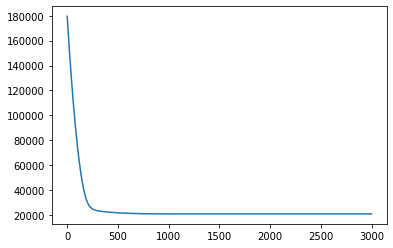

In [64]:
plt.plot(train_hist)

In [65]:
def generate_submission(net, test_x):
    preds = net(test_x).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    return submission

In [66]:
submission = generate_submission(net, test_X)

In [67]:
submission

,Id,SalePrice
0,1461,113533.015625
1,1462,162230.312500
2,1463,189839.781250
3,1464,213817.125000
4,1465,179009.234375
...,...,...
1454,2915,69799.757812
1455,2916,86020.484375
1456,2917,193274.625000
1457,2918,99834.210938


### K折验证

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

### 坑
1. 参数全是nan:
    - 原因: 梯度爆炸
    - 解决: 简化 输入层, 删掉隐藏层
2. Adam 收敛不了: 
    - 增大 迭代次数
    - 增大 learning rate